# Кросс валидация

Используется для того чтобы выбрать модель из некоторого множества вариантов
Есть несколько методов

**Тестирование на отложенной выборке** - Разбиваем данные на группы заранее. Как правило нужно применять если данных много и модель учится долго

**K-fold** - разбиваем на фолды, на одном тестим на остальных обучаемся и так K раз

**Leave One Out** - экстремальный K-Fold когда оставляем один объект на тест

### Подготовим данные

In [92]:
import numpy as np
import pandas as pd
from geo import *
import lightgbm
from sklearn import model_selection

In [91]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
df = pd.read_csv("data/ny_taxi_fare_1m.csv").drop(['Unnamed: 0'], axis=1)

In [12]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,18.0,2015-02-23 15:59:15 UTC,-73.980843,40.747425,-74.004707,40.708378,1
1,18.9,2009-07-14 09:22:00 UTC,-73.979997,40.762613,-74.010148,40.703322,1
2,52.0,2015-04-09 20:03:00 UTC,-73.989105,40.746273,-73.990692,40.746906,1
3,11.5,2013-07-04 01:26:00 UTC,-74.006647,40.743880,-73.989765,40.720782,5
4,8.9,2010-08-06 19:15:39 UTC,-73.988505,40.748976,-73.974706,40.736039,1


In [18]:
df['pickup_datetime'] = df.pickup_datetime.astype("datetime64")

Признак длина поездки должно быть очень информативен

In [23]:
df['dist'] = earth_distance(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)

Время и дата тоже могут влиять

In [ ]:
df['month'] = df.pickup_datetime.dt.month

In [68]:
df['hour'] = df.pickup_datetime.dt.hour

Самую малось почитим данные

In [51]:
df = df[(df.fare_amount != 0) & (df.dist > 500) & (df.dist < 100000)]

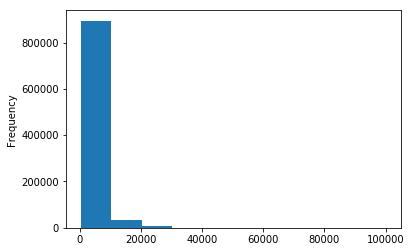

In [54]:
df.dist.plot(kind='hist')

In [146]:
def extract_data(extr_df):
    X = extr_df.drop(['fare_amount', 'pickup_datetime'], axis=1).values
    y = extr_df.fare_amount.values
    return X, y

In [147]:
X, y = extract_data(df)

Попробуем что-нибудь обучить 

## Тестирование на отложенной выборке

In [111]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=2019)

In [115]:
y_pred = np.ones_like(y_test) * np.median(y_train)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 41.37727646918887


In [116]:
regr = lightgbm.LGBMRegressor(objective='mape')

In [117]:
regr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='mape',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [118]:
y_pred = regr.predict(X_test)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 16.43713506861734


## K-fold

In [119]:
kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=2019)

In [120]:
y_pred = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = lightgbm.LGBMRegressor(objective='mape')
    regr.fit(X_train, y_train)
    y_pred.extend(regr.predict(X_test))
y_pred = np.array(y_pred)

In [125]:
y_pred = regr.predict(X_test)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 18.37526061659183


## Есть сомнения?

In [126]:
def df_time_hist(time_s):
    return time_s.groupby([df["pickup_datetime"].dt.year, df["pickup_datetime"].dt.month]).count().plot(figsize=(20, 8), kind="bar")

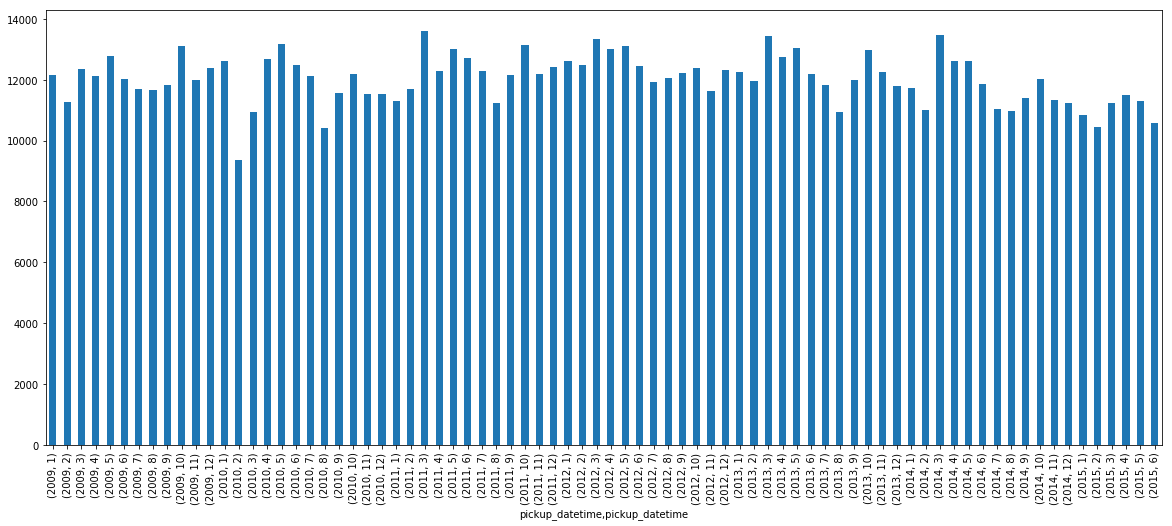

In [127]:
df_time_hist(df.pickup_datetime)

Посмотрим на среднюю цену за каждый год

In [138]:
df.groupby(df.pickup_datetime.dt.year)[['fare_amount']].mean()

,fare_amount
pickup_datetime,
2009,10.164359
2010,10.251178
2011,10.514173
2012,11.325546
2013,12.752329
2014,13.026675
2015,13.118228


Видим что цена растет. Это значит что качество полученное на валидации не честное, тк реальные данные будут отличаться от текущих.

## Разобьем выборку по времени

In [143]:
train_ind = df.pickup_datetime.dt.year < 2014
test_ind = ~train_ind

In [148]:
X_train, y_train = extract_data(df[train_ind])
X_test, y_test = extract_data(df[test_ind])

In [149]:
X_train.shape, X_test.shape

((731249, 8), (207242, 8))

In [150]:
regr = lightgbm.LGBMRegressor(objective='mape')
regr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='mape',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [151]:
y_pred = regr.predict(X_test)
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAPE: 22.23291626904562


Качество ухудшилось. Хотя метод все тот же.

Но теперь мы больше ему доверяем.

**Если имеем дело с временными данными, безопаснее разбивать по времени, если нет оснований делать по другому.**